In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
def load_data(file_path='PKLM_pro_portal.xlsx'):
    data = pd.read_excel(file_path, sheet_name='data').rename(
        columns={'rok': 'year', 'měsíc': 'month', 'den': 'day'}
    )

    data['date'] = data.apply(
        lambda r: datetime(r['year'], r['month'], r['day']), axis=1
    )
    return data.drop(['SRA', 'Flag'], axis='columns')

def add_baseline(data, baseline_range=(1920, 1950)):
    baseline_mask = (
        (data['year'] >= baseline_range[0]).values &
        (data['year'] < baseline_range[1]).values
    )

    agg_dict = {'T-AVG': np.mean, 'TMI': np.mean, 'TMA': np.mean}
    rename_dict = {'T-AVG': 'T-AVG-BASE', 'TMI': 'TMI-BASE', 'TMA': 'TMA-BASE'}
    baseline = data[baseline_mask].groupby(['month', 'day']).agg(
        agg_dict).reset_index().rename(columns=rename_dict)
    return data.merge(
        baseline, how='left', left_on=['month', 'day'], right_on=['month', 'day'])

def compute_anomalies(data):
    window_size = 11 * 365
    for metric in ['T-AVG', 'TMA', 'TMI']:
        metric_base = '{}-BASE'.format(metric)
        metric_anomaly = '{}-ANOMALY'.format(metric)
        metric_anomaly_11y = '{}-ANOMALY-11Y'.format(metric)
        metric_anomaly_11y_std = '{}-ANOMALY-11Y-STD'.format(metric)

        data[metric_anomaly] = data[metric] - data[metric_base]
        data[metric_anomaly_11y] = data[metric_anomaly].rolling(
            window=window_size
        ).mean()
        data[metric_anomaly_11y_std] = data[metric_anomaly].rolling(
            window=window_size
        ).std()

    return data

data = load_data()
data = compute_anomalies(add_baseline(data))

In [8]:
def compute_model(data, year_range):
    model = LinearRegression()
    mask = (
        (data['year'] >= year_range[0]).values &
        (data['year'] < year_range[1]).values &
        ~data['T-AVG-ANOMALY-11Y'].isna()
    )
    x = data.loc[mask, ['year']].values
    y = data.loc[mask, 'T-AVG-ANOMALY-11Y']
    model.fit(x, y)
    
    return model.coef_, model.intercept_, r2_score(y, model.predict(x))

In [13]:
def generate_plot(data):
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    x = data['date'].tolist()
    y = data['T-AVG-ANOMALY-11Y']
    ax.plot(x, y, 'b', alpha=0.8, label='11 year moving average baseline difference')
    ax.plot([x[0], x[-1]], [0, 0], 'g--', alpha=0.5, label='1920-1950 baseline')
    ax.set_title('Temperature 1775-2020 at Klementinum, Prague, Czech Republic')
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature Anomaly [°C]')

    for i, x_model in enumerate([[1780, 1950], [1975, 2020]]):
        a, b, r2 = compute_model(data, x_model)
        label = 'Trend {}-{}, a={:.3f}, R2={:.3f}'.format(x_model[0], x_model[1], a[0], r2)
        
        x = [datetime(x, 1, 1) for x in x_model]
        y = [a * x + b for x in x_model]
        ax.plot(x, y, 'r' if i else 'y', label=label)

    plt.legend()
    plt.show()

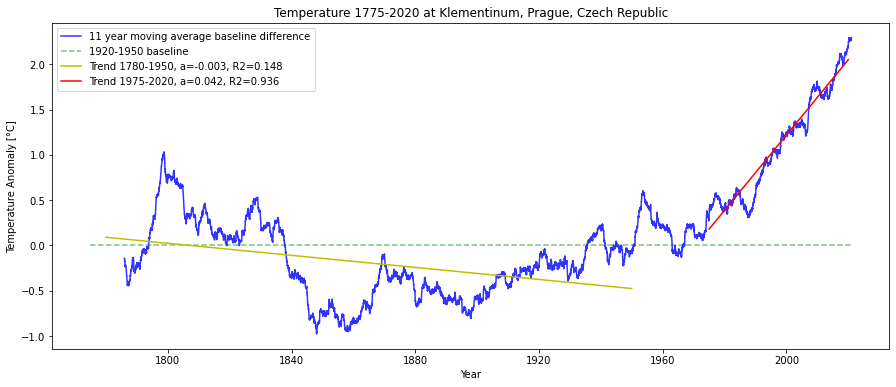

In [14]:
generate_plot(data)